In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row

### Priprava podatkov

In [27]:
lj_dez = pd.read_csv("../ljubljana_dez_2010_2023.csv")

# Nastavljanje pravilnega časovnega pasu
lj_dez['NastanekDatumCas'] = pd.to_datetime(lj_dez['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
lj_dez['NastanekDatumCas'] = lj_dez['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {lj_dez['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy

Preverila bom, če se ritmičnost nesreč, ki so se zgodile v dežju, razlikuje od ritmičnosti nesreč, ki so se zgodile v lepem vremenu. Za nesreče v dežju bom upoštevala vse nesreče, pri katerih je količina padlega dežja vsaj 1.0 mm/h.

In [28]:
# Maska za dež
rain_mask = (lj_dez['SkupenDez'] < 1.0)

lj_dez = lj_dez[rain_mask]
# display(lj_dez)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = lj_dez['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNice",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

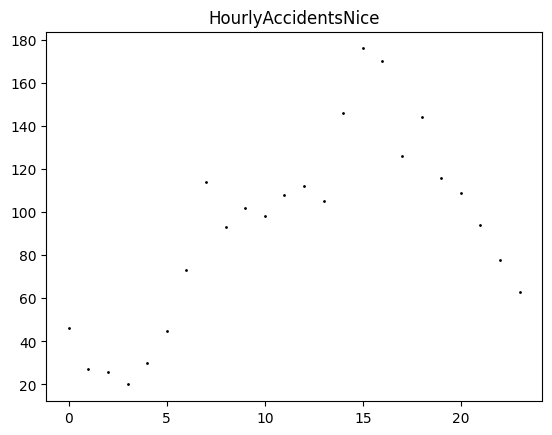

In [29]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNice"])

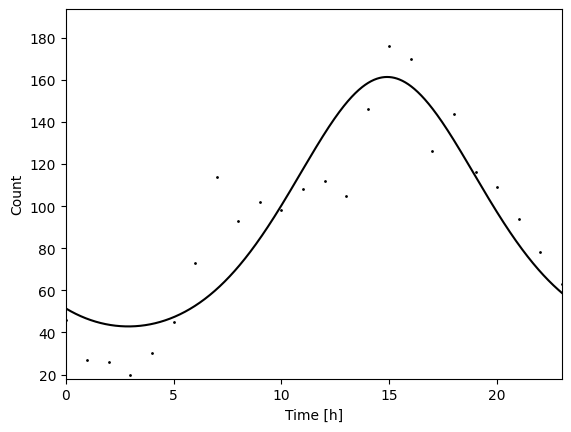

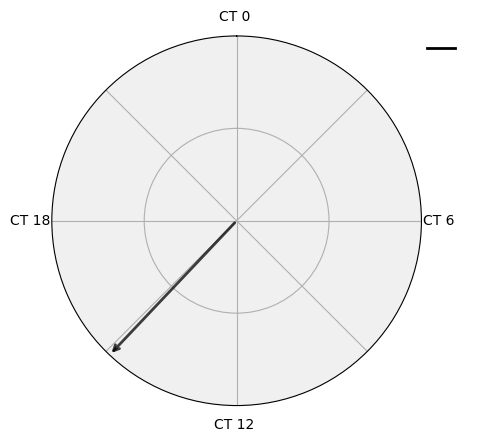

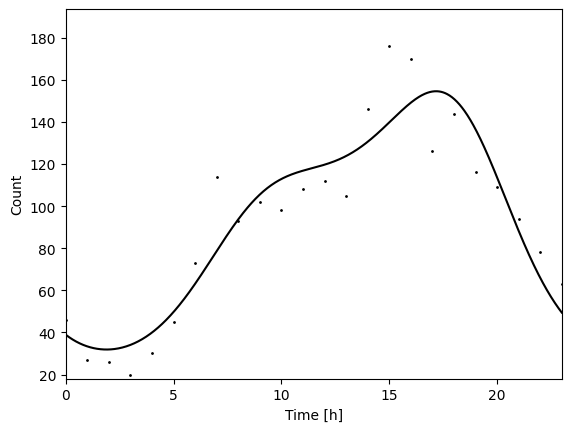

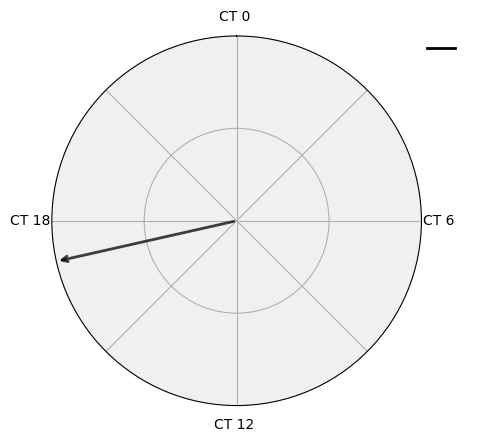

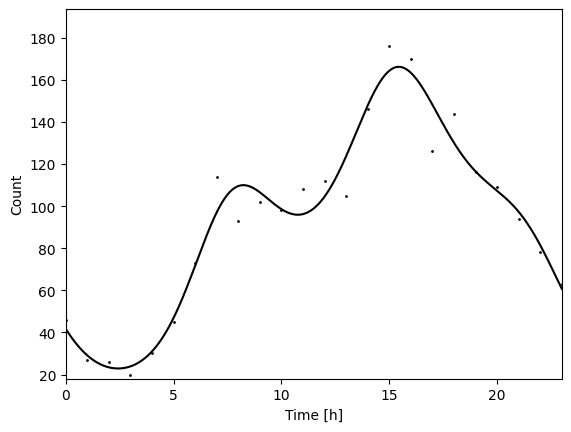

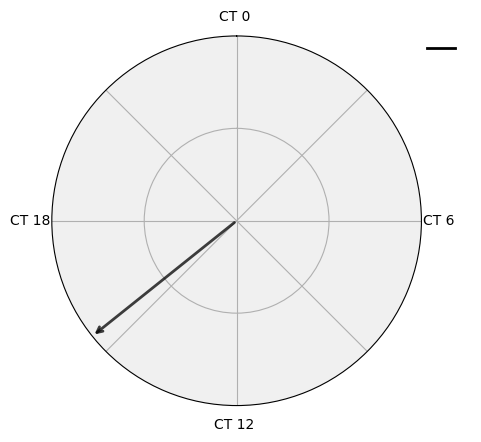

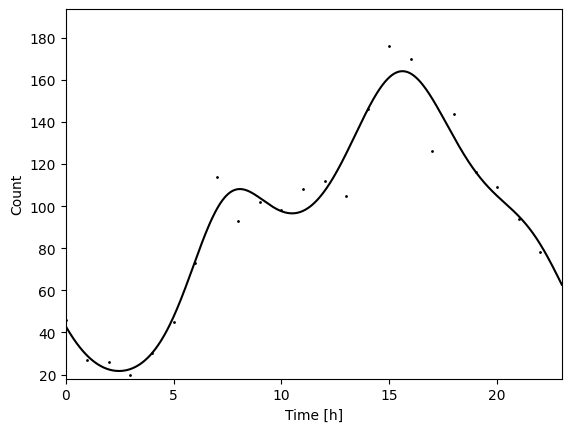

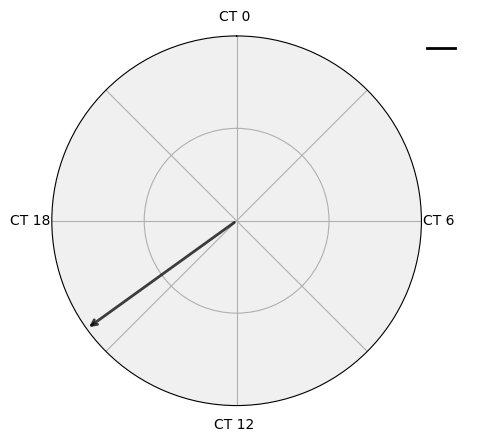

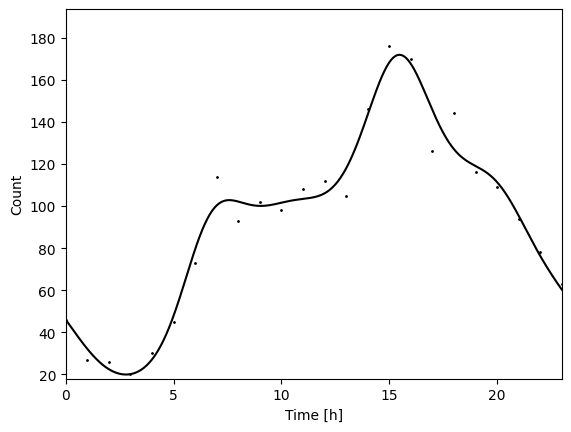

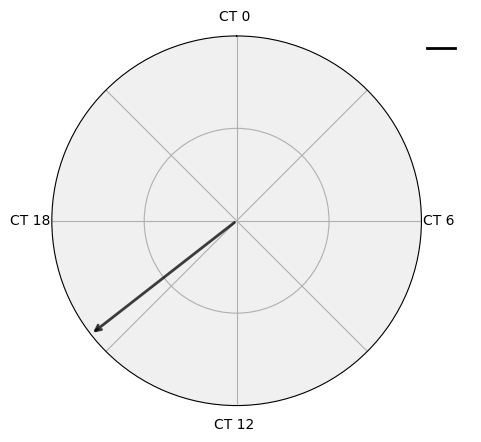

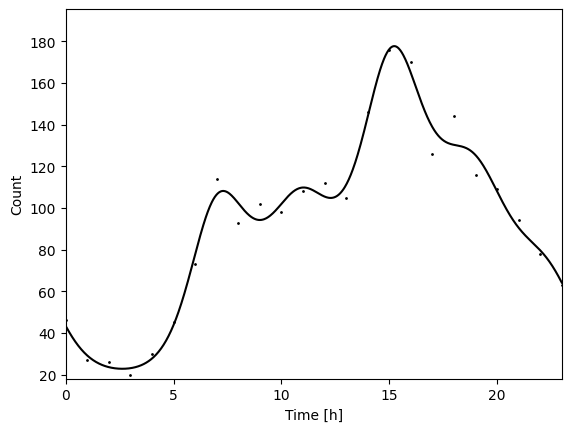

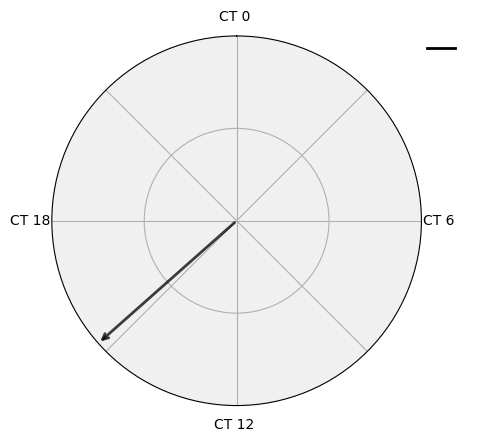

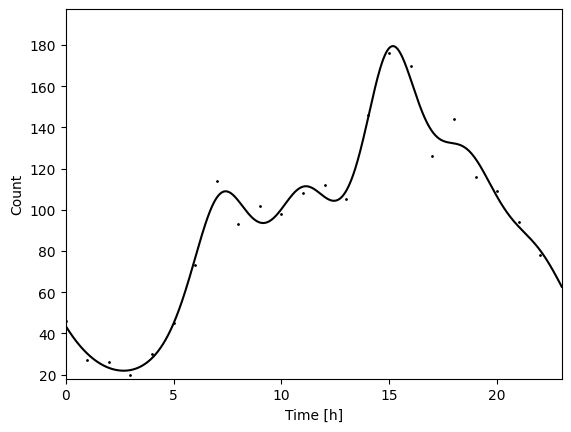

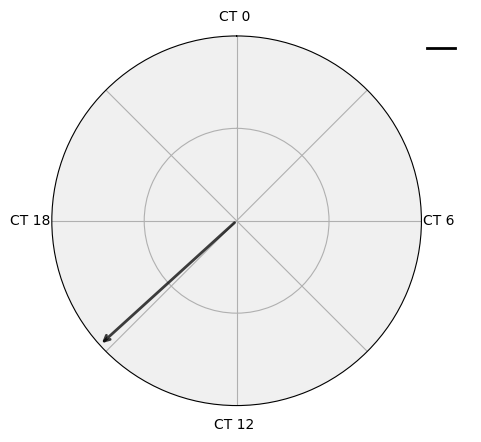

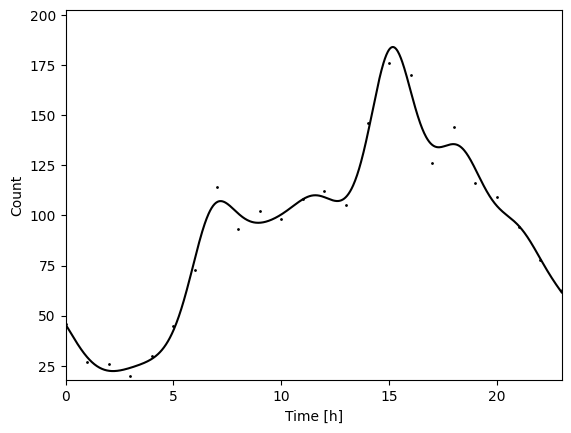

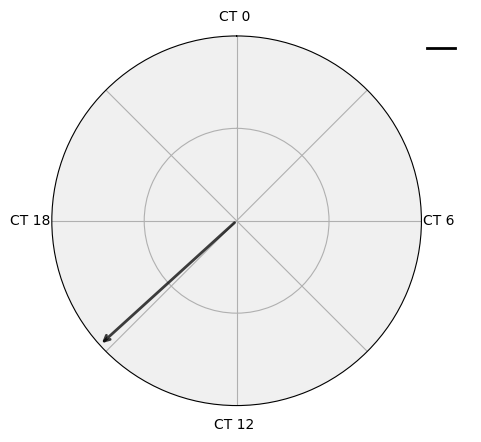

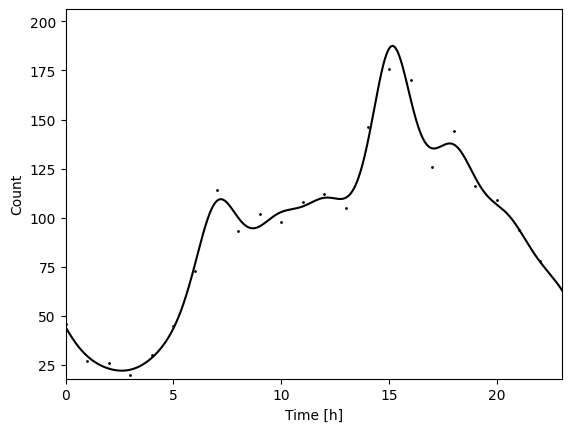

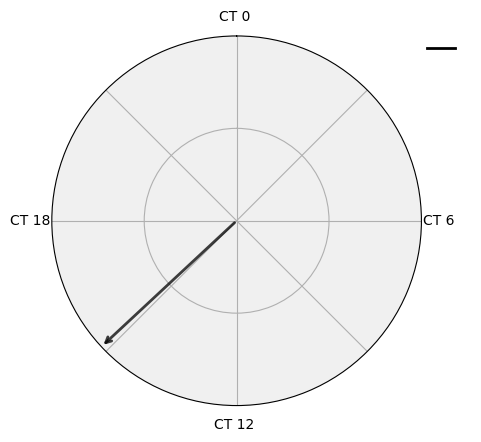

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


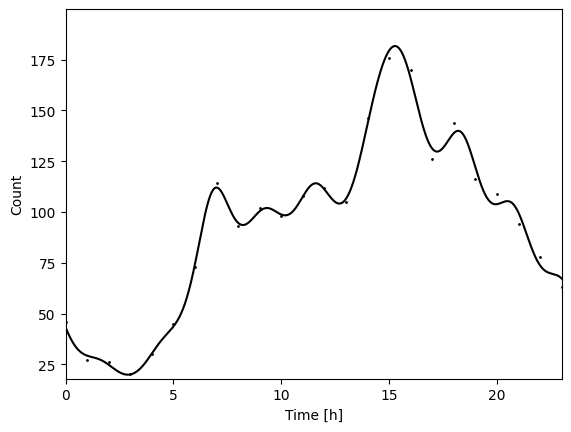

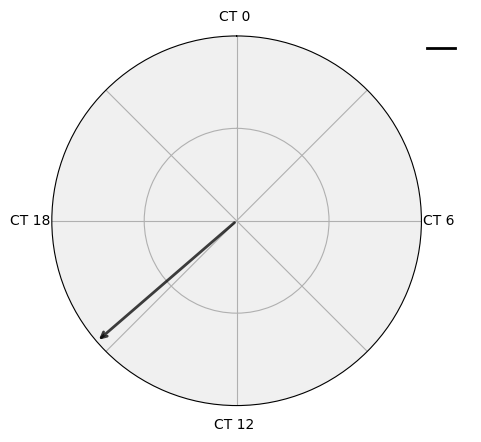

In [30]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNice', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [31]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNice,24.0,1.0,1.282723e-09,1.282723e-09,9525.948411,-106.062954,0.161804,59.257252,2.383711,102.104461,[14.894894894894895],[161.36171299987797],[2.8828828828828827],[42.84751135004846]
1,HourlyAccidentsNice,24.0,2.0,1.311978e-11,1.457753e-11,6164.742343,-98.098006,0.224750,61.357741,1.792500,93.229337,[17.153153153153152],[154.5858592884928],[1.8738738738738738],[31.872176822935142]
2,HourlyAccidentsNice,24.0,3.0,1.960274e-16,4.512975e-16,2078.210351,-83.491115,0.340185,71.662084,2.245342,94.525331,"[8.216216216216216, 15.423423423423424]","[109.96670743290669, 166.1847717236775]",[2.4024024024024024],[22.864898616489704]
3,HourlyAccidentsNice,24.0,4.0,1.733824e-15,2.167279e-15,2088.995849,-82.946434,0.344490,71.218557,2.195027,92.893333,"[8.072072072072071, 15.615615615615615]","[108.1153956812948, 164.11188976071188]",[2.4504504504504503],[21.67597860336196]
4,HourlyAccidentsNice,24.0,5.0,5.603156e-16,8.004509e-16,1380.936537,-79.071180,0.375115,75.978923,2.232764,95.904388,"[7.591591591591592, 15.471471471471471]","[102.81897980355741, 171.88331069244074]",[2.7867867867867866],[19.925464769987673]
5,HourlyAccidentsNice,24.0,6.0,3.996806e-17,1.998403e-16,848.824834,-73.626015,0.418147,77.453384,2.295658,100.230184,"[7.303303303303303, 11.05105105105105, 15.2312...","[108.15322280361553, 109.80581237372613, 177.6...","[2.6426426426426426, 8.984984984984985]","[22.777527372310246, 94.20796521593458]"
6,HourlyAccidentsNice,24.0,7.0,2.064460e-16,4.512975e-16,808.226875,-73.001572,0.423082,78.775820,2.308237,100.666700,"[7.3993993993994, 11.147147147147146, 15.18318...","[108.96690414252193, 111.42823302001182, 179.4...","[2.6906906906906904, 9.12912912912913]","[21.890879677472594, 93.57560708700716]"
7,HourlyAccidentsNice,24.0,8.0,2.256487e-16,4.512975e-16,626.249455,-70.753148,0.440851,80.884917,2.308237,103.201417,"[7.207207207207207, 11.57957957957958, 15.1831...","[107.16245586398944, 110.08204629104779, 184.0...","[2.21021021021021, 8.936936936936936]","[22.316798949371364, 96.33553393578677]"
8,HourlyAccidentsNice,24.0,9.0,4.781009e-16,7.968349e-16,636.874270,-69.346456,0.451968,82.697550,2.320816,104.798617,"[7.207207207207207, 12.156156156156156, 15.135...","[109.43731812141615, 110.26512462753408, 187.4...","[2.5945945945945947, 8.696696696696696]","[22.10106761537174, 94.61964320652645]"
9,HourlyAccidentsNice,24.0,10.0,9.970461e-19,9.970461e-18,253.299994,-59.961939,0.526132,80.886994,2.283079,100.771009,"[7.015015015015015, 9.32132132132132, 11.57957...","[111.98973362597545, 101.9261848019516, 114.08...","[2.8828828828828827, 8.216216216216216, 10.186...","[19.884015249397454, 93.55200840108633, 98.315..."


### Katero je najboljše število komponent

In [32]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNice,24.0,3.0,1.960274e-16,4.512975e-16,2078.210351,-83.491115,0.340185,71.662084,2.245342,94.525331,"[8.216216216216216, 15.423423423423424]","[109.96670743290669, 166.1847717236775]",[2.4024024024024024],[22.864898616489704]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


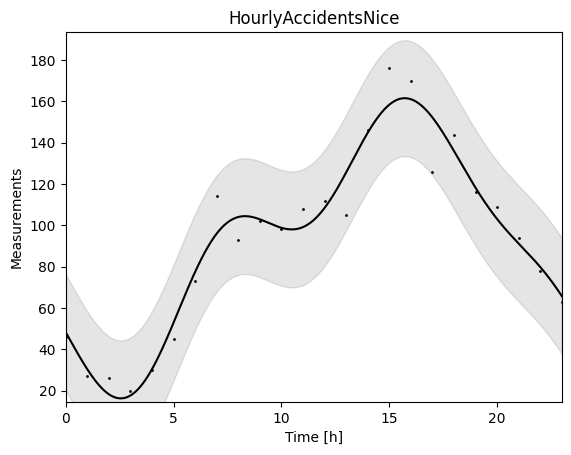

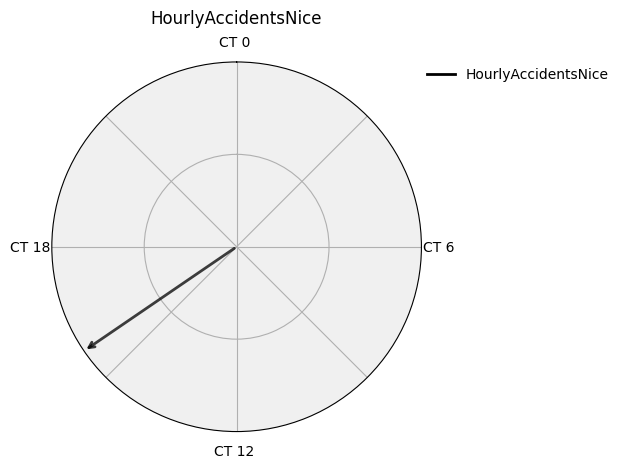

In [35]:
cosinor.plot_df_models(df_plot, df_best_model)